# Creating a simple Time to Event Model to test with our data

In [ ]:
#!pip install lifelines

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
import lifelines
from  lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter
from  lifelines.fitters.coxph_fitter import CoxPHFitter
#import lifelines.KaplanMeierFitter as KaplanMeierFitter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


load in the training data

In [ ]:
#data = pd.read_csv("/content/drive/MyDrive/01-Classes/08Semester/CSDS491/CSDS491CourseProject/data/train.csv") #Sakin's directory
data = pd.read_csv("/content/drive/MyDrive/Case/Graph Class/train.csv") #Josh's directory
data.head()

,Unnamed: 0,MassScore,VolumeScore,Area2D,NumLesion3D,isAgZero,isLesion3DBelow5,AgGroupX1,AgGroupX2,AgGroupX3,...,female,smokingstatus,Baseline.BMI,IBD,SLE,Psoriasis,RA,BASELINE_DM,DM,Status
0,0,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,33.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,11.391991,95.593929,38.623810,12.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,36.50,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,2,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,30.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,21.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,14.425980,76.675415,30.975342,3.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,33.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.shape

(3366, 75)

check columns

In [ ]:
data.columns

Index(['Unnamed: 0', 'MassScore', 'VolumeScore', 'Area2D', 'NumLesion3D',
       'isAgZero', 'isLesion3DBelow5', 'AgGroupX1', 'AgGroupX2', 'AgGroupX3',
       'numLesionPerArtery3D_LM1', 'numLesionPerArtery3D_LAD1',
       'numLesionPerArtery3D_LCX1', 'numLesionPerArtery3D_RCA1', 'isArt2plus',
       'isArt3plus', 'numArtCalc', 'AgastonScorePerArtery2D_LM1',
       'AgastonScorePerArtery2D_LAD1', 'AgastonScorePerArtery2D_LCX1',
       'AgastonScorePerArtery2D_RCA1', 'MassScorePerArtery_LM1',
       'MassScorePerArtery_LAD1', 'MassScorePerArtery_LCX1',
       'MassScorePerArtery_RCA1', 'VolumeScorePerArtery_LM1',
       'VolumeScorePerArtery_LAD1', 'VolumeScorePerArtery_LCX1',
       'VolumeScorePerArtery_RCA1', 'massHist1', 'massHist2', 'massHist3',
       'massHist4', 'massHist5', 'avrHist1', 'avrHist2', 'avrHist3',
       'avrHist4', 'avrHist5', 'DistTop2LastLesionPerArtery_LM1',
       'DistTop2LastLesionPerArtery_LAD1', 'DistTop2LastLesionPerArtery_LCX1',
       'DistTop2LastLesion

recursive feature elimination to get the best features

In [ ]:
# isolate variable names
vars = data.columns.values.tolist()
y = ["Status","Time"]
x = [var for var in vars if var not in y]

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
# initalize the logreg
logreg = LogisticRegression()

# perform recursive feature elimination -> gives 20 best features
import warnings
selector = RFE(estimator=logreg, n_features_to_select=20, step=1)
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  selector = selector.fit(data[x], data["Status"].values.ravel())

# print some metrics
print(selector.support_)
print(selector.ranking_)

[False  True False False False  True  True False False False False False
 False False False False False False False False  True  True  True  True
 False False False  True  True False False False False False False False
 False False False False  True False False  True  True False False  True
  True False False False False  True  True False False False False False
 False False False  True False  True  True False False False False  True
 False]
[ 6  1 23 13 27  1  1  9 20 48 10 17  8 18 29 52 41 22 15 37  1  1  1  1
 36 12  5  1  1 45 51 31 53 46 38 35 49 43 54  4  1 16 25  1  1 47  7  1
  1 30 24 26 34  1  1 44  2  3 21 33 32 19 14  1 11  1  1 42 50 39 40  1
 28]


In [ ]:
# separate X and Y
X = data[x]
Y = data[y]

take the "true" variables to use in the model

In [ ]:
# get the variables to use in the model
vars_model = [x[i] for i in range(len(x)) ]#if selector.support_[i] == True]
vars_model

['Unnamed: 0',
 'MassScore',
 'VolumeScore',
 'Area2D',
 'NumLesion3D',
 'isAgZero',
 'isLesion3DBelow5',
 'AgGroupX1',
 'AgGroupX2',
 'AgGroupX3',
 'numLesionPerArtery3D_LM1',
 'numLesionPerArtery3D_LAD1',
 'numLesionPerArtery3D_LCX1',
 'numLesionPerArtery3D_RCA1',
 'isArt2plus',
 'isArt3plus',
 'numArtCalc',
 'AgastonScorePerArtery2D_LM1',
 'AgastonScorePerArtery2D_LAD1',
 'AgastonScorePerArtery2D_LCX1',
 'AgastonScorePerArtery2D_RCA1',
 'MassScorePerArtery_LM1',
 'MassScorePerArtery_LAD1',
 'MassScorePerArtery_LCX1',
 'MassScorePerArtery_RCA1',
 'VolumeScorePerArtery_LM1',
 'VolumeScorePerArtery_LAD1',
 'VolumeScorePerArtery_LCX1',
 'VolumeScorePerArtery_RCA1',
 'massHist1',
 'massHist2',
 'massHist3',
 'massHist4',
 'massHist5',
 'avrHist1',
 'avrHist2',
 'avrHist3',
 'avrHist4',
 'avrHist5',
 'DistTop2LastLesionPerArtery_LM1',
 'DistTop2LastLesionPerArtery_LAD1',
 'DistTop2LastLesionPerArtery_LCX1',
 'DistTop2LastLesionPerArtery_RCA1',
 'DistFirst2LastLesionPerArtery_LM1',
 'DistF

In [ ]:
X_rfe = X[vars_model]
X_rfe.head()

,Unnamed: 0,MassScore,VolumeScore,Area2D,NumLesion3D,isAgZero,isLesion3DBelow5,AgGroupX1,AgGroupX2,AgGroupX3,...,Age_right,female,smokingstatus,Baseline.BMI,IBD,SLE,Psoriasis,RA,BASELINE_DM,DM
0,0,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,55.0,0.0,0.0,33.43,0.0,0.0,0.0,0.0,0.0,0.0
1,1,11.391991,95.593929,38.623810,12.0,0.0,0.0,1.0,0.0,0.0,...,68.0,1.0,1.0,36.50,0.0,0.0,0.0,0.0,1.0,1.0
2,2,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,38.0,0.0,0.0,30.35,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,68.0,1.0,0.0,21.32,0.0,0.0,0.0,0.0,0.0,0.0
4,4,14.425980,76.675415,30.975342,3.0,0.0,1.0,1.0,0.0,0.0,...,48.0,1.0,1.0,33.76,0.0,0.0,0.0,0.0,0.0,0.0


Creating Kaplan Meier Curve

<Axes: xlabel='timeline'>

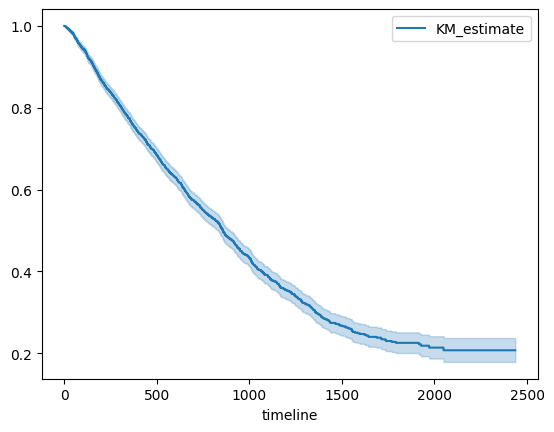

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(durations = Y["Time"].values, event_observed = Y["Status"].values)
kmf.plot_survival_function()

Creating our Cox Model

In [ ]:
cph = CoxPHFitter(penalizer=1)

Fitting our data in the model

In [ ]:
cph.fit(data, duration_col  = "Time", event_col = "Status")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3366 total observations, 1683 right-censored observations>
             duration col = 'Time'
                event col = 'Status'
                penalizer = 1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 3366
number of events observed = 1683
   partial log-likelihood = -11887.88
         time fit was run = 2023-04-18 15:51:03 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
Unnamed: 0                           0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
MassScore                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VolumeScore                          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Area2D                               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
NumLesion3D                          0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
isAgZero                            -0.12       0.88       0.04            -0.20            -0.05                 0.82                 0.95
isLesion3DBelow5                    -0.03       0.97       0.03            -0.10             0.03                 0.91                 1.03
AgGroupX1                            0.13       1.13       0.04             0.05             0.20                 1.05                 1.22
AgGroupX2                            0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
AgGroupX3                           -0.01       0.99       0.04            -0.08             0.06                 0.92                 1.06
numLesionPerArtery3D_LM1             0.07       1.07       0.03             0.02             0.12                 1.02                 1.13
numLesionPerArtery3D_LAD1            0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
numLesionPerArtery3D_LCX1            0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
numLesionPerArtery3D_RCA1           -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
isArt2plus                           0.01       1.01       0.03            -0.05             0.08                 0.95                 1.08
isArt3plus                           0.02       1.02       0.03            -0.05             0.08                 0.95                 1.09
numArtCalc                           0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05
AgastonScorePerArtery2D_LM1          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AgastonScorePerArtery2D_LAD1         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AgastonScorePerArtery2D_LCX1         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
AgastonScorePerArtery2D_RCA1        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MassScorePerArtery_LM1              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MassScorePerArtery_LAD1              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MassScorePerArtery_LCX1              0.00       1.00       0.00           

Plotting Proportional Hazards

<Axes: xlabel='log(HR) (95% CI)'>

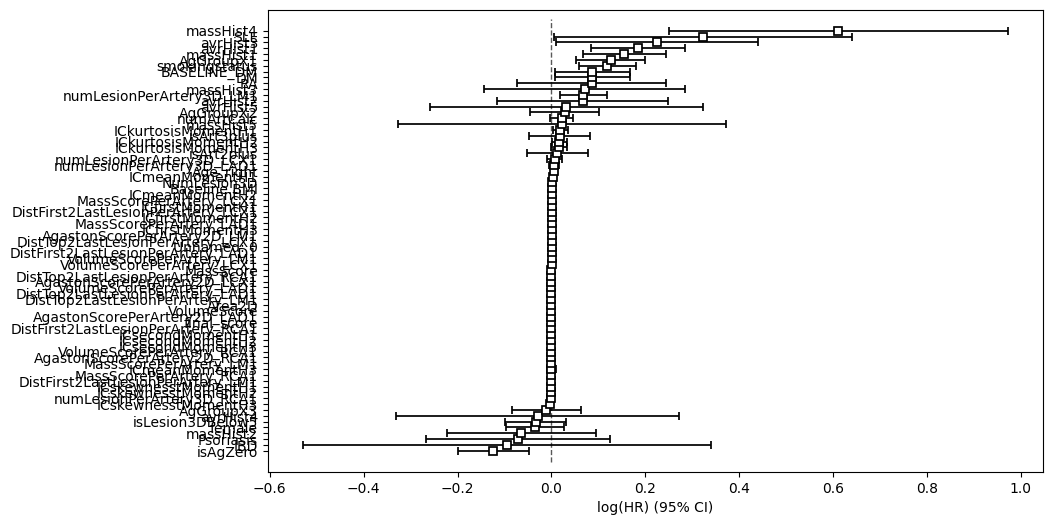

In [ ]:
plt.subplots(figsize = (10, 6))
cph.plot()

Checking the variation of our Model

<Axes: >

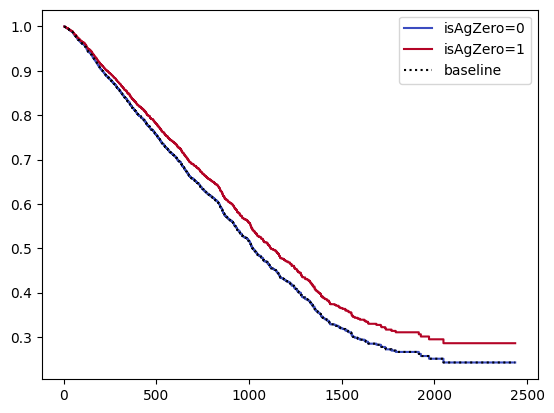

In [ ]:
cph.plot_partial_effects_on_outcome(covariates = 'isAgZero', values = [0,1], cmap = 'coolwarm')

# Checking the significance of our predictors

if the p-value of the feature is greater than 0.05 than the predictor is explained well by the model. If there are variable less than 0.05 than they are not well explained so they can be removed in future iterations

In [ ]:
cph.check_assumptions(data, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3366 total observations, 1683 right-censored observations>
         test_name = proportional_hazard_test

---
                                         test_statistic      p  -log2(p)
AgGroupX1                          km              3.22   0.07      3.78
                                   rank            4.02   0.04      4.48
AgGroupX2                          km              0.49   0.48      1.05
                                   rank            0.61   0.43      1.21
AgGroupX3                          km              0.13   0.72      0.47
                                   rank            0.20   0.65      0.62
AgastonScorePerArtery2D_LAD1       km              0.08   0.78      0.36
                                   rank            0.12   0.73      0.45
AgastonScorePerArtery2D_LCX1       km              0.22   0.64      0.65
                                   rank            0.27   0.60      0.74
AgastonScorePerArtery2D_LM1        km              0.48   0.49      1.04
                                   rank            0.80   0.37      1.43
AgastonScorePerArtery2D_RCA1       km              0.08   0.77      0.37
                                   rank            0.06   0.81      0.31
Age_right                          km              2.62   0.11      3.25
                                   rank            2.75   0.10      3.36
Area2D                             km              0.02   0.90      0.16
                                   rank            0.04   0.85      0.23
BASELINE_DM                        km              2.47   0.12      3.11
                                   rank            2.64   0.10      3.26
Baseline.BMI                       km              0.47   0.49      1.02
                                   rank            0.71   0.40      1.33
DM                                 km              2.47   0.12      3.11
                                   rank            2.64   0.10      3.26
DistFirst2LastLesionPerArtery_LAD1 km              0.51   0.48      1.07
                                   rank            0.25   0.61      0.70
DistFirst2LastLesionPerArtery_LCX1 km              0.00   0.96      0.05
                                   rank            0.04   0.83      0.26
DistFirst2LastLesionPerArtery_LM1  km              0.55   0.46      1.13
                                   rank            0.76   0.38      1.38
DistFirst2LastLesionPerArtery_RCA1 km              0.17   0.68      0.56
                                   rank            0.10   0.75      0.42
DistTop2LastLesionPerArtery_LAD1   km              0.01   0.91      0.13
                                   rank            0.05   0.82      0.29
DistTop2LastLesionPerArtery_LCX1   km              0.01   0.90      0.15
                                   rank            0.01   0.91      0.14
DistTop2LastLesionPerArtery_LM1    km              4.79   0.03      5.12
                                   rank            5.19   0.02      5.46
DistTop2LastLesionPerArtery_RCA1   km              0.01   0.91      0.13
                                   rank            0.01   0.91      0.14
IBD                                km              0.02   0.88      0.18
                                   rank            0.00   0.97      0.05
ICfirstMomentH1                    km              0.11   0.74      0.43
                                   rank            0.13   0.72      0.47
ICfirstMomentH2                    km              0.29   0.59      0.76
                                   rank            0.27   0.60      0.74
ICfirstMomentH3                    km              0.07   0.80      0.33
                                   rank            0.05   0.82      0.29
ICkurtosisMomentH1                 km              0.04   0.85      0.24
                                   rank            0.06   0.81      0.3



1. Variable 'Unnamed: 0' failed the non-proportional test: p-value is 0.0020.

   Advice 1: the functional form of the variable 'Unnamed: 0' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Unnamed: 0' using pd.cut, and then specify it in
`strata=['Unnamed: 0', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'AgGroupX1' failed the non-proportional test: p-value is 0.0449.

   Advice 1: the functional form of the variable 'AgGroupX1' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a 

[]

Load in the testing dataset to test the model

In [ ]:
#test_XY = pd.read_csv("/content/drive/MyDrive/01-Classes/08Semester/CSDS491/CSDS491CourseProject/data/test.csv") #Sakin's directory
test_XY = pd.read_csv("/content/drive/MyDrive/Case/Graph Class/test.csv") #Josh's directory

X_test = test_XY[vars_model]
Y_test = test_XY["Status"]

X_test.head()

,Unnamed: 0,MassScore,VolumeScore,Area2D,NumLesion3D,isAgZero,isLesion3DBelow5,AgGroupX1,AgGroupX2,AgGroupX3,...,Age_right,female,smokingstatus,Baseline.BMI,IBD,SLE,Psoriasis,RA,BASELINE_DM,DM
0,1224,10.236033,62.452927,24.981171,4.0,0.0,1.0,1.0,0.0,0.0,...,78.0,0.0,1.0,29.840,0.0,0.0,0.0,0.0,0.0,0.0
1,263,122.015518,755.190849,303.983688,30.0,0.0,0.0,0.0,0.0,1.0,...,64.0,0.0,0.0,31.940,0.0,0.0,0.0,0.0,0.0,0.0
2,1580,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,61.0,1.0,0.0,29.935,0.0,0.0,0.0,0.0,0.0,0.0
3,1315,6.859407,37.911892,15.164757,2.0,0.0,1.0,1.0,0.0,0.0,...,63.0,1.0,0.0,21.620,0.0,0.0,0.0,0.0,0.0,0.0
4,1169,36.141647,208.282471,83.312988,5.0,0.0,1.0,0.0,1.0,0.0,...,42.0,0.0,0.0,25.557,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_pred_time = cph.predict_expectation(test_XY)
y_pred = cph.predict_partial_hazard(test_XY)

Accuracy score is not too great, let's check the confusion matrix

57
[[177 258]
 [  3  54]]


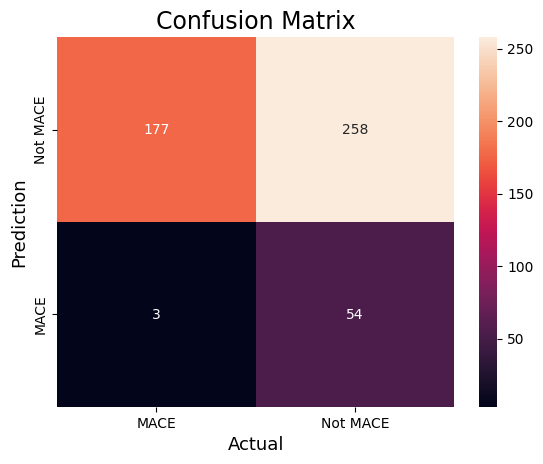

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix = confusion_matrix(Y_test, y_pred>0.5)
print(sum(Y_test==1))
print(confusion_matrix)
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='g',
            xticklabels=['MACE','Not MACE'],
            yticklabels=['Not MACE','MACE'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

Okay, so this means there were 248+3 correct predictions and 54+187 incorrect predictions

We can build the ROC curve to see how good our classifier is. A straight line from the bottom left to top right would be random while a curve that nears the top left would be good

0.7220004033071183


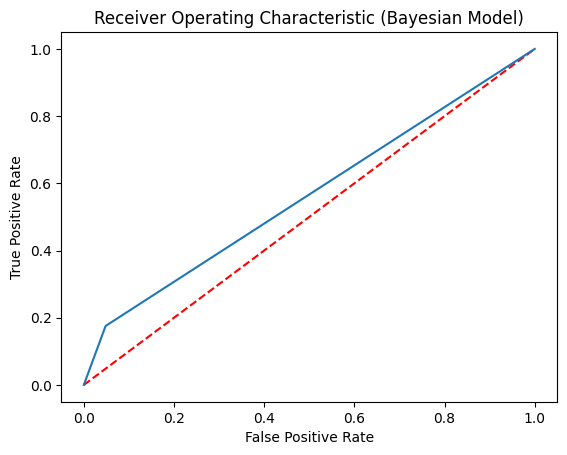

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_XY['Status'], y_pred>1.5)
auc = roc_auc_score(test_XY['Status'], y_pred)
print(auc)
fig, ax = plt.subplots()
ax.plot([0,1], [0,1], "r--")
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title("Receiver Operating Characteristic (Bayesian Model)")
plt.show()

Our ROC curve demonstrates that this logistic regression model does not do the greatest job of distinguishing between whether an individual has died or is still alive based on the features that were included. Potential ways to improve might include performing extensive data cleaning.

Text(0.5, 1.0, 'Stratification based on Bayesian Model')

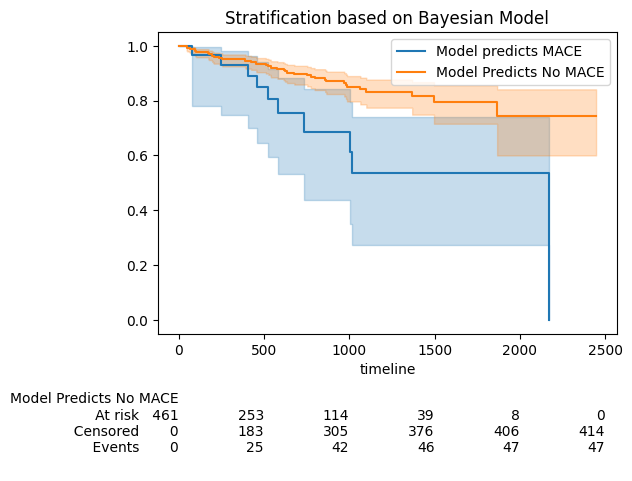

In [ ]:
ax = plt.subplot(111)
m = (y_pred>1.5)
kmf.fit(durations = test_XY.Time[m], event_observed = test_XY.Status[m], label = "Model predicts MACE")
kmf.plot_survival_function(ax = ax)
kmf.fit(durations = test_XY.Time[~m], event_observed = test_XY.Status[~m], label = "Model Predicts No MACE")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
plt.ylim(-0.05, 1.05)
plt.title("Stratification based on Bayesian Model")

In [ ]:
def fit_and_score_features2(X):
   y=X[["Status","Time"]]
   X.drop(["TIme", "Status"], axis=1, inplace=True)
   n_features = X.shape[1]
   scores = np.empty(n_features)
   m = CoxPHFitter()

   for j in range(n_features):
       Xj = X.iloc[:, j:j+1]
       Xj=pd.merge(Xj, y,  how='right', left_index=True, right_index=True)
       m.fit(Xj, duration_col="Time", event_col="Status", show_progress=True)
       scores[j] = m.score_
   return scores

In [ ]:
fit_and_score_features2(X)

Text(0, 0.5, 'Frequency')

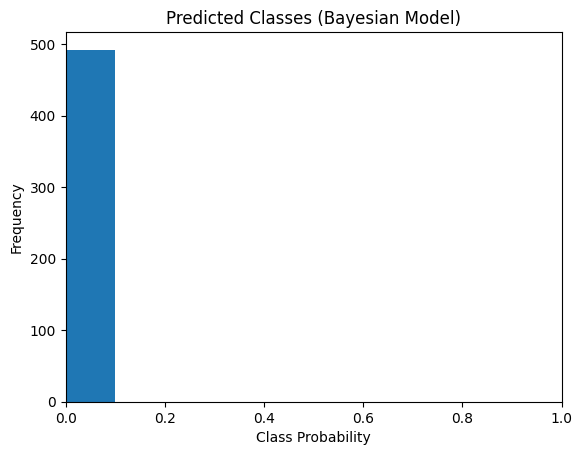

In [ ]:
plt.hist((test_XY.Status==1.5)*1)
plt.xlim([0,1])
plt.title('Predicted Classes (Bayesian Model)')
plt.xlabel('Class Probability')
plt.ylabel('Frequency')

In [ ]:
test_XY.Status[m]